# **Partie 2: Comparaison des embeddings visuels**

## **Méthodes pour extraire les embeddings visuels :**

 ###  **Méthode 1 : Modèle entraîné pour la classification.**

In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
import numpy as np
from PIL import ImageOps, Image
from io import BytesIO
from collections import Counter
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import numpy as np
from PIL import Image, ImageOps, ImageFilter
from PIL import Image
from io import BytesIO
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from scipy.spatial import Voronoi
import umap

In [ ]:
def download_and_save_images(df, main_folder="all_images", img_width=224, img_height=224):
    """Downloads, resizes, and saves images to specified directory."""
    os.makedirs(main_folder, exist_ok=True)
    for index, row in df.iterrows():
        image_url = row['imageurl']
        category2 = row['category2_code']
        try:
            response = requests.get(image_url, stream=True)
            response.raise_for_status()
            image = Image.open(BytesIO(response.content))
            # Convertion de chaque image au mode RGB
            image = image.convert('RGB')
            # Redimenssionnement des images
            image = image.resize((img_width, img_height))
            # Normalisation de l'image
            normalized_array = np.array(image) / 255.0  # Normalisation entre 0 et 1
            # Conversion en image normalisée
            normalized_image = Image.fromarray((normalized_array * 255).astype(np.uint8))
            subfolder_path = os.path.join(main_folder, category2)
            os.makedirs(subfolder_path, exist_ok=True)
            image_path = os.path.join(subfolder_path, f"{index}.jpg")
            image.save(image_path)
            print(f"Image downloaded and saved to: {image_path}")
        except Exception as e:
            print(f"Error processing image {image_url}: {e}")

In [ ]:
def create_data_generators(img_width, img_height, batch_size):
    """Creates training and validation data generators with augmentation."""
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        horizontal_flip=True,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        vertical_flip=False,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest',
        data_format="channels_last",
        preprocessing_function=preprocess_input
        )

    validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_generator = train_datagen.flow_from_directory(
        'all_images',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    validation_generator = validation_datagen.flow_from_directory(
        'all_images',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )
    return train_generator, validation_generator

In [ ]:
def build_and_train_model(train_generator, validation_generator, epochs=10):
    """Builds and trains the CNN model."""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(train_generator.num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True
    )
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        #callbacks=[early_stopping]
    )
    return model, history

In [ ]:
# Chargment des données
df = pd.read_parquet("hf://datasets/DBQ/Chanel.Product.prices.Germany/data/train-00000-of-00001-d681c47b79d4401f.parquet")

# 1. Téléchargement des images redimenssionnées et normalisées et les enregister dans un dossiers
img_width, img_height = 224, 224
download_and_save_images(df, img_width=img_width, img_height=img_height)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Image downloaded and saved to: all_images/HANDBAGS/0.jpg
Error processing image https://res.cloudinary.com/dwayrkp5z/image/fetch/h_400,w_400,c_fill_pad,g_auto,e_trim/n.a.: 400 Client Error: Bad Request for url: https://res.cloudinary.com/dwayrkp5z/image/fetch/h_400,w_400,c_fill_pad,g_auto,e_trim/n.a.
Image downloaded and saved to: all_images/BLUE LIGHT GLASSES/2.jpg
Image downloaded and saved to: all_images/SUNGLASSES/3.jpg
Image downloaded and saved to: all_images/SUNGLASSES/4.jpg
Image downloaded and saved to: all_images/SUNGLASSES/5.jpg
Image downloaded and saved to: all_images/SUNGLASSES/6.jpg
Image downloaded and saved to: all_images/SUNGLASSES/7.jpg


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Image downloaded and saved to: all_images/RINGS/8.jpg
Image downloaded and saved to: all_images/COCO CRUSH/9.jpg
Image downloaded and saved to: all_images/COCO CRUSH/10.jpg
Image downloaded and saved to: all_images/COCO CRUSH/11.jpg
Image downloaded and saved to: all_images/EYEGLASSES/12.jpg
Image downloaded and saved to: all_images/EYEGLASSES/13.jpg
Image downloaded and saved to: all_images/RINGS/14.jpg
Image downloaded and saved to: all_images/COCO CRUSH/15.jpg
Image downloaded and saved to: all_images/BRACELETS/16.jpg
Image downloaded and saved to: all_images/NECKLACES/17.jpg
Image downloaded and saved to: all_images/COCO CRUSH/18.jpg
Error processing image https://res.cloudinary.com/dwayrkp5z/image/fetch/h_400,w_400,c_fill_pad,g_auto,e_trim/https://www.chanel.com/images//t_one/q_auto:good,f_auto,fl_lossy,dpr_1.1/w_620/extrait-de-camelia-single-earring-pink-pink-gold-diamond-packshot-default-j12119-9516008833054.jpg: 404 Client Error: Not Found for url: https://res.cloudinary.com/dw

In [ ]:
# Chargment des données
df = pd.read_parquet("hf://datasets/DBQ/Chanel.Product.prices.Germany/data/train-00000-of-00001-d681c47b79d4401f.parquet")

# 1. Téléchargement des images redimenssionnées et normalisées et les enregister dans un dossiers
img_width, img_height = 224, 224
download_and_save_images(df, img_width=img_width, img_height=img_height)

# 2. Création d'un générateur de data
batch_size = 32
train_generator, validation_generator = create_data_generators(img_width, img_height, batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Image downloaded and saved to: all_images/HANDBAGS/0.jpg
Error processing image https://res.cloudinary.com/dwayrkp5z/image/fetch/h_400,w_400,c_fill_pad,g_auto,e_trim/n.a.: 400 Client Error: Bad Request for url: https://res.cloudinary.com/dwayrkp5z/image/fetch/h_400,w_400,c_fill_pad,g_auto,e_trim/n.a.
Image downloaded and saved to: all_images/BLUE LIGHT GLASSES/2.jpg
Image downloaded and saved to: all_images/SUNGLASSES/3.jpg
Image downloaded and saved to: all_images/SUNGLASSES/4.jpg
Image downloaded and saved to: all_images/SUNGLASSES/5.jpg
Image downloaded and saved to: all_images/SUNGLASSES/6.jpg
Image downloaded and saved to: all_images/SUNGLASSES/7.jpg
Image downloaded and saved to: all_images/RINGS/8.jpg


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Image downloaded and saved to: all_images/COCO CRUSH/9.jpg
Image downloaded and saved to: all_images/COCO CRUSH/10.jpg
Image downloaded and saved to: all_images/COCO CRUSH/11.jpg
Image downloaded and saved to: all_images/EYEGLASSES/12.jpg
Image downloaded and saved to: all_images/EYEGLASSES/13.jpg
Image downloaded and saved to: all_images/RINGS/14.jpg
Image downloaded and saved to: all_images/COCO CRUSH/15.jpg
Image downloaded and saved to: all_images/BRACELETS/16.jpg
Image downloaded and saved to: all_images/NECKLACES/17.jpg
Image downloaded and saved to: all_images/COCO CRUSH/18.jpg
Error processing image https://res.cloudinary.com/dwayrkp5z/image/fetch/h_400,w_400,c_fill_pad,g_auto,e_trim/https://www.chanel.com/images//t_one/q_auto:good,f_auto,fl_lossy,dpr_1.1/w_620/extrait-de-camelia-single-earring-pink-pink-gold-diamond-packshot-default-j12119-9516008833054.jpg: 404 Client Error: Not Found for url: https://res.cloudinary.com/dwayrkp5z/image/fetch/h_400,w_400,c_fill_pad,g_auto,e_tr

In [ ]:
# 3. Entrainement du modèle
epochs = 50
model, history = build_and_train_model(train_generator, validation_generator, epochs=epochs)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.1858 - loss: 3.8813 - val_accuracy: 0.1250 - val_loss: 3.8460
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2500 - loss: 3.0913 - val_accuracy: 0.0000e+00 - val_loss: 4.6939
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.3329 - loss: 2.7487 - val_accuracy: 0.0938 - val_loss: 3.5219
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1875 - loss: 3.1536 - val_accuracy: 0.0385 - val_loss: 3.5316
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.3232 - loss: 2.6698 - val_accuracy: 0.1771 - val_loss: 4.2617
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4062 - loss: 2.7048 - val_accuracy: 0.1154 - val_loss: 4.3986
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - accuracy: 0.3769 - loss: 2.3588 - val_accuracy: 0.1875 - val_loss: 3.1004
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 256ms/step - accuracy: 0.5312 - loss: 1.6205 - val_accuracy: 0.07

* **Extraction des embeddings des images de la méthode 1**

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 173056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │      11,075,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 49)                  │           3,185 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,405,461 (127.43 MB)

 Trainable params: 11,135,153 (42.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,270,308 (84.95 MB)

In [ ]:
# Initialise les générateurs
img_width, img_height, batch_size = 224, 224, 32
train_generator, validation_generator = create_data_generators(img_width, img_height, batch_size)

# Récupérer toutes les données d'entraînement
x_train, y_train = [], []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    x_train.append(x_batch)
    y_train.append(y_batch)

x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

Found 976 images belonging to 49 classes.
Found 218 images belonging to 49 classes.
x_train shape: (976, 224, 224, 3)
y_train shape: (976, 49)


In [ ]:
intermediate_layer_model = tf.keras.Model(inputs=model.layers[0].input, outputs=model.get_layer('flatten_2').output)

image_embeddings = intermediate_layer_model.predict(x_train)

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
reduced_embeddings = tsne.fit_transform(image_embeddings)

31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step


In [ ]:
intermediate_layer_model = tf.keras.Model(inputs=model.layers[0].input, outputs=model.get_layer('flatten').output)

image_embeddings = intermediate_layer_model.predict(x_train)

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
reduced_embeddings = tsne.fit_transform(image_embeddings)

29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 567ms/step


* **Visualisation des embeddings des images pour le modèle CNN**

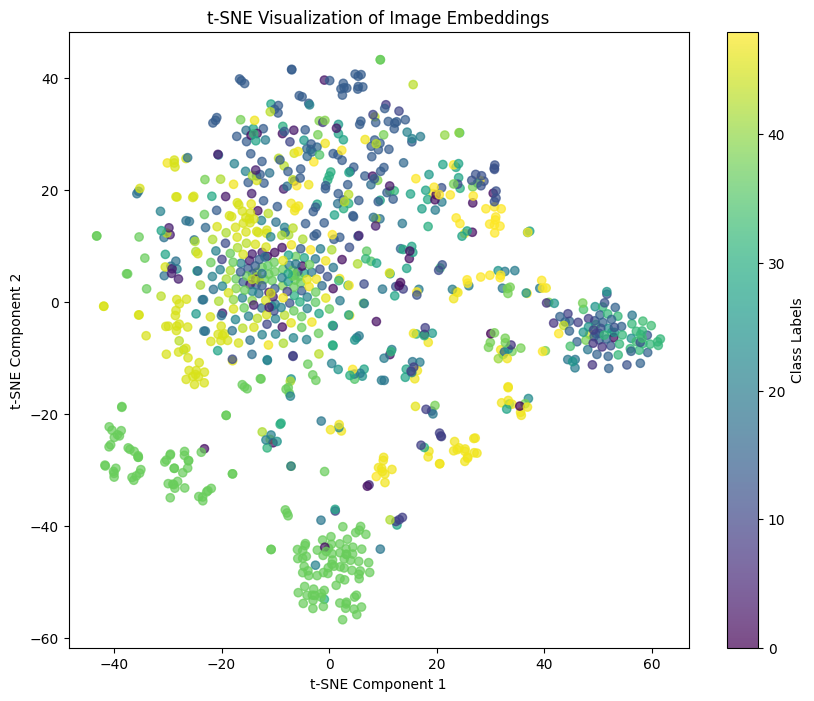

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=np.argmax(y_train, axis=1), cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class Labels')
plt.title("t-SNE Visualization of Image Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [ ]:
fig = go.Figure(data=go.Scatter(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    mode='markers+text',
    marker=dict(color=np.argmax(y_train, axis=1)),
    text=[f"Class: {label}" for label in np.argmax(y_train, axis=1)]
))

fig.update_layout(
    title="t-SNE Visualization of Image Embeddings (Plotly)",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2",
    height=800
)

fig.show()

In [ ]:
fig = go.Figure(data=go.Scatter(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    mode='markers',
    marker=dict(color=np.argmax(y_train, axis=1)),
    text=[f"Class: {label}" for label in np.argmax(y_train, axis=1)]
))

fig.update_layout(
    title="t-SNE Visualization of Image Embeddings (Plotly)",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2",
    height=800
)

fig.show()

* **Sauvegarde des embeddings des images pour le modèle CNN**

In [ ]:
df['image_embedding'] = [[] for _ in range(len(df))]

for i in range(min(len(df), len(image_embeddings))):
    df.at[i, 'image_embedding'] = image_embeddings[i].tolist()

df.to_parquet('df_with_embeddings.parquet')

from google.colab import files
files.download('df_with_embeddings.parquet')

In [ ]:
df.head()

,website_name,competence_date,country_code,currency_code,brand,category1_code,category2_code,category3_code,product_code,title,itemurl,imageurl,full_price,price,full_price_eur,price_eur,flg_discount,image_embedding
0,Chanel,2023-11-17,DEU,EUR,CHANEL,FASHION,HANDBAGS,N.A.,PAS4152B13455,Tweed & goldfarbenes Metall Schwarz Rosa & B...,https://www.chanel.com/de/mode/p/AS4152B13455N...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5200.0,5200.0,5200.0,5200.0,0,"[0.0, 0.08078163117170334, 0.02873796597123146..."
1,Chanel,2023-11-17,DEU,EUR,CHANEL,FASHION,HANDBAGS,N.A.,PA67085Y09953,n.a.,https://www.chanel.com/de/mode/p/A67085Y099539...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5750.0,5750.0,5750.0,5750.0,0,"[0.0, 0.1975964456796646, 0.0, 0.1373511552810..."
2,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,BLUE LIGHT GLASSES,N.A.,PA71441,Schwarz,https://www.chanel.com/de/brillen/p/A71441X081...,https://res.cloudinary.com/dwayrkp5z/image/fet...,420.0,420.0,420.0,420.0,0,"[0.0, 0.0, 0.058397646993398666, 0.0, 0.022517..."
3,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,SUNGLASSES,N.A.,PA71449,Silberfarben. Gläser: Braun Mit Verlauf,https://www.chanel.com/de/brillen/p/A71449X099...,https://res.cloudinary.com/dwayrkp5z/image/fet...,580.0,580.0,580.0,580.0,0,"[0.0, 0.0, 0.09510398656129837, 0.0, 0.0, 0.0,..."
4,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,SUNGLASSES,N.A.,PA71466,Blau & Rosa. Gläser: Grau Mit Verlauf,https://www.chanel.com/de/brillen/p/A71466X010...,https://res.cloudinary.com/dwayrkp5z/image/fet...,480.0,480.0,480.0,480.0,0,"[0.0, 0.0, 0.08915071934461594, 0.0, 0.0, 0.0,..."


* Les couleurs permettent de distinguer visuellement les classes.
Le texte (text) attaché à chaque point permet d'explorer les informations contextuelles en survol.

In [ ]:
labels = train_generator.classes[:len(reduced_embeddings)]

unique_labels = np.unique(labels)
colors = [f"rgba({np.random.randint(0,255)},{np.random.randint(0,255)},{np.random.randint(0,255)},0.8)" for _ in unique_labels]

label_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}
mapped_colors = [label_color_map[label] for label in labels]

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=reduced_embeddings[:, 0],
        y=reduced_embeddings[:, 1],
        mode="markers",
        marker=dict(
            color=mapped_colors,
            size=10,
            line=dict(width=1, color='black')
        ),
        text=labels,
        name="Image Embeddings"
    )
)

fig.update_layout(
    title="t-SNE Visualization of Image Embeddings",
    xaxis_title="t-SNE Dimension 1",
    yaxis_title="t-SNE Dimension 2",
    legend_title="Classes",
    template="plotly_white"
)

fig.show()

* Une autre manière intéressante de visualiser les clusters consiste à utiliser des graphes de densité ou des diagrammes de Voronoï dans l'espace 2D ou 3D pour représenter les clusters de manière plus analytique.

In [ ]:
import plotly.graph_objects as go
import numpy as np

labels = train_generator.classes[:len(reduced_embeddings)]

unique_labels = np.unique(labels)
colors = [f"rgba({np.random.randint(0,255)},{np.random.randint(0,255)},{np.random.randint(0,255)},0.8)" for _ in unique_labels]

label_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}
mapped_colors = [label_color_map[label] for label in labels]

fig = go.Figure()

tsne = TSNE(n_components=3, random_state=42)
reduced_embeddings = tsne.fit_transform(image_embeddings)

fig.add_trace(
    go.Scatter3d(
        x=reduced_embeddings[:, 0],
        y=reduced_embeddings[:, 1],
        z=reduced_embeddings[:, 2],
        mode="markers",
        marker=dict(
            size=5,
            color=mapped_colors,
            opacity=0.8,
            line=dict(width=1, color="black")
        ),
        text=labels,
        name="Image Embeddings"
    )
)

fig.update_layout(
    title="3D t-SNE Visualization of Image Embeddings",
    scene=dict(
        xaxis_title="t-SNE Dimension 1",
        yaxis_title="t-SNE Dimension 2",
        zaxis_title="t-SNE Dimension 3"
    ),
    template="plotly_white"
)

fig.show()

* 1. Graphique de densité (Contour Plot en 2D)

In [ ]:
labels = train_generator.classes[:len(reduced_embeddings)]
unique_labels = np.unique(labels)
colors = [f"rgba({np.random.randint(0,255)},{np.random.randint(0,255)},{np.random.randint(0,255)},0.8)" for _ in unique_labels]
label_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}
mapped_colors = [label_color_map[label] for label in labels]

x = reduced_embeddings[:, 0]
y = reduced_embeddings[:, 1]

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=x,
        y=y,
        mode='markers',
        marker=dict(color=mapped_colors, size=10),
        text=labels,
        name="Points"
    )
)

fig.add_trace(
    go.Histogram2dContour(
        x=x,
        y=y,
        colorscale='Blues',
        contours=dict(showlabels=True),
        name="Density"
    )
)

fig.update_layout(
    title="Cluster Density Visualization (2D)",
    xaxis_title="t-SNE Dimension 1",
    yaxis_title="t-SNE Dimension 2",
    template="plotly_white"
)

fig.show()


* 2. Diagramme de Voronoï
Le diagramme de Voronoï divise l'espace en régions autour des points centraux (dans ce cas, les embeddings des images). Cela peut être utile pour visualiser les frontières des clusters.

In [ ]:
import plotly.graph_objects as go
from scipy.spatial import Voronoi, voronoi_plot_2d

vor = Voronoi(reduced_embeddings[:, :2])

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=reduced_embeddings[:, 0],
        y=reduced_embeddings[:, 1],
        mode='markers',
        marker=dict(color=mapped_colors, size=10),
        text=labels,
        name="Points"
    )
)

for simplex in vor.ridge_vertices:
    simplex = np.asarray(simplex)
    if np.all(simplex >= 0):
        fig.add_trace(
            go.Scatter(
                x=vor.vertices[simplex, 0],
                y=vor.vertices[simplex, 1],
                mode='lines',
                line=dict(color='gray'),
                showlegend=False
            )
        )

fig.update_layout(
    title="Voronoi Diagram for Clusters",
    xaxis_title="t-SNE Dimension 1",
    yaxis_title="t-SNE Dimension 2",
    template="plotly_white"
)

fig.show()

### **Méthode 2 : Utilisation d’un modèle pré-entraîné.**

In [ ]:
img_width, img_height = 224, 224
batch_size = 32
train_generator2, validation_generator2 = create_data_generators(img_width, img_height, batch_size)

def build_and_train_pretrained_model(train_generator, validation_generator, epochs=10):
    """Builds and trains a pre-trained ResNet50 model."""
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size
    )

    return model, history

Found 976 images belonging to 49 classes.
Found 218 images belonging to 49 classes.


In [ ]:
epochs = 30
model2, history2 = build_and_train_pretrained_model(train_generator2, validation_generator2, epochs=epochs)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 883s 28s/step - accuracy: 0.4120 - loss: 2.5533 - val_accuracy: 0.0417 - val_loss: 3.6405
Epoch 2/30
 1/30 ━━━━━━━━━━━━━━━━━━━━ 15:07 31s/step - accuracy: 0.6562 - loss: 1.6227

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 477ms/step - accuracy: 0.6562 - loss: 1.6227 - val_accuracy: 0.0769 - val_loss: 3.5713
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 825s 27s/step - accuracy: 0.7505 - loss: 0.9256 - val_accuracy: 0.0208 - val_loss: 3.8301
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 31s 201ms/step - accuracy: 0.7188 - loss: 0.9560 - val_accuracy: 0.0000e+00 - val_loss: 4.0315
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 819s 27s/step - accuracy: 0.8704 - loss: 0.4597 - val_accuracy: 0.0052 - val_loss: 3.8436
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 186ms/step - accuracy: 0.8438 - loss: 0.4654 - val_accuracy: 0.0385 - val_loss: 3.7220
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 801s 27s/step - accuracy: 0.8991 - loss: 0.3510 - val_accuracy: 0.0208 - val_loss: 3.8442
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 203ms/step - accuracy: 0.9375 - loss: 0.2861 - val_accuracy: 0.0000e+00 - val_loss: 3.9432
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 827s 26s/step - accuracy: 0.9218 - loss: 0.2543 - val_accuracy: 0

* **Evaluation du modèle de la méthode 2**

In [ ]:
loss, accuracy = model2.evaluate(validation_generator2)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.8848 - loss: 0.4507
Test Loss: 0.3309
Test Accuracy: 0.9048


* **Extraction des embeddings par le modèle de la méthode 2**

In [ ]:
model2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 77,102,101 (294.12 MB)

 Trainable params: 25,682,993 (97.97 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 51,365,988 (195.95 MB)

In [ ]:
x_train, y_train = [], []
for _ in range(len(train_generator2)):
    x_batch, y_batch = next(train_generator2)
    x_train.append(x_batch)
    y_train.append(y_batch)

x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

x_train shape: (976, 224, 224, 3)
y_train shape: (976, 49)


* **Visualisation des embeddings des images pour le modèle ResNet50**

18/18 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step


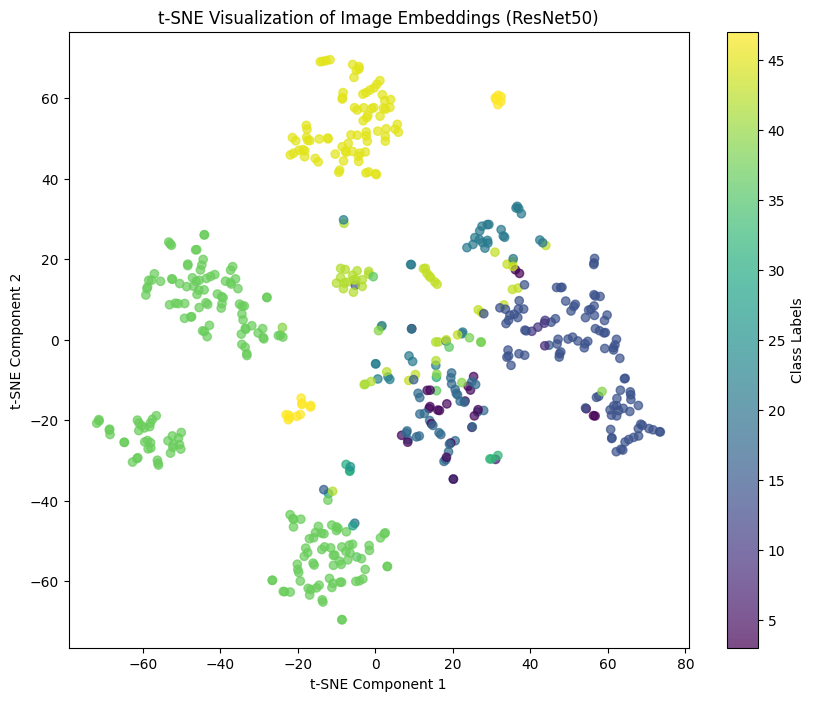

In [ ]:
intermediate_layer_model2 = tf.keras.Model(inputs=model2.input, outputs=model2.get_layer('global_average_pooling2d').output)

image_embeddings2 = intermediate_layer_model2.predict(x_train)

tsne2 = TSNE(n_components=2, random_state=42, perplexity=5)
reduced_embeddings2 = tsne2.fit_transform(image_embeddings2)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings2[:, 0], reduced_embeddings2[:, 1], c=np.argmax(y_train, axis=1), cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class Labels')
plt.title("t-SNE Visualization of Image Embeddings (ResNet50)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [ ]:
fig = go.Figure(data=go.Scatter(
    x=reduced_embeddings2[:, 0],
    y=reduced_embeddings2[:, 1],
    mode='markers+text',
    marker=dict(color=np.argmax(y_train, axis=1)),
    text=[f"Class: {label}" for label in np.argmax(y_train, axis=1)]
))

fig.update_layout(
    title="t-SNE Visualization of Image Embeddings (Plotly)",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2",
    height=800
)

fig.show()

In [ ]:
fig = go.Figure(data=go.Scatter(
    x=reduced_embeddings2[:, 0],
    y=reduced_embeddings2[:, 1],
    mode='markers',
    marker=dict(color=np.argmax(y_train, axis=1)),
    text=[f"Class: {label}" for label in np.argmax(y_train, axis=1)]
))

fig.update_layout(
    title="t-SNE Visualization of Image Embeddings (Plotly)",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2",
    height=800
)

fig.show()

* **Sauvegarde des embeddings pour le modèle ResNet50**

In [ ]:
df['image_embedding2'] = [[] for _ in range(len(df))]

for i in range(min(len(df), len(image_embeddings2))):
    df.at[i, 'image_embedding2'] = image_embeddings2[i].tolist()

df.to_parquet('df_with_embeddings2.parquet')

from google.colab import files
files.download('df_with_embeddings2.parquet')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(f"Nombre de lignes complétées : {df['image_embedding2'].apply(lambda x: len(x) > 0).sum()} sur {len(df)}")

Nombre de lignes complétées : 976 sur 1428


In [ ]:
df.head()

,website_name,competence_date,country_code,currency_code,brand,category1_code,category2_code,category3_code,product_code,title,itemurl,imageurl,full_price,price,full_price_eur,price_eur,flg_discount,image_embedding2
0,Chanel,2023-11-17,DEU,EUR,CHANEL,FASHION,HANDBAGS,N.A.,PAS4152B13455,Tweed & goldfarbenes Metall Schwarz Rosa & B...,https://www.chanel.com/de/mode/p/AS4152B13455N...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5200.0,5200.0,5200.0,5200.0,0,"[0.047071319073438644, 0.0, 0.0469184592366218..."
1,Chanel,2023-11-17,DEU,EUR,CHANEL,FASHION,HANDBAGS,N.A.,PA67085Y09953,n.a.,https://www.chanel.com/de/mode/p/A67085Y099539...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5750.0,5750.0,5750.0,5750.0,0,"[0.0, 0.001596460584551096, 0.3064392209053039..."
2,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,BLUE LIGHT GLASSES,N.A.,PA71441,Schwarz,https://www.chanel.com/de/brillen/p/A71441X081...,https://res.cloudinary.com/dwayrkp5z/image/fet...,420.0,420.0,420.0,420.0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.05442395806312561,..."
3,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,SUNGLASSES,N.A.,PA71449,Silberfarben. Gläser: Braun Mit Verlauf,https://www.chanel.com/de/brillen/p/A71449X099...,https://res.cloudinary.com/dwayrkp5z/image/fet...,580.0,580.0,580.0,580.0,0,"[0.0, 0.018143076449632645, 0.0, 0.00900305900..."
4,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,SUNGLASSES,N.A.,PA71466,Blau & Rosa. Gläser: Grau Mit Verlauf,https://www.chanel.com/de/brillen/p/A71466X010...,https://res.cloudinary.com/dwayrkp5z/image/fet...,480.0,480.0,480.0,480.0,0,"[0.0, 0.0, 0.0, 0.012996802106499672, 0.0, 0.1..."


### **Méthode 2 : Modéle pré-entrainé 2**



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_and_train_inception_model(train_generator, validation_generator, epochs=10):
    """Builds and trains a pre-trained InceptionV3 model."""
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size
    )

    return model, history

epochs = 20
inception_model1, inception_history1 = build_and_train_inception_model(train_generator2, validation_generator2, epochs=epochs)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - accuracy: 0.2782 - loss: 3.2075 - val_accuracy: 0.5677 - val_loss: 1.6089
Epoch 2/20
 1/30 ━━━━━━━━━━━━━━━━━━━━ 2:52 6s/step - accuracy: 0.4688 - loss: 1.8730

/usr/lib/python3.10/contextlib.py:153: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.4688 - loss: 1.8730 - val_accuracy: 0.6923 - val_loss: 1.2528
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - accuracy: 0.5893 - loss: 1.6277 - val_accuracy: 0.6667 - val_loss: 1.2364
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.6562 - loss: 1.4617 - val_accuracy: 0.8462 - val_loss: 0.7733
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 158s 5s/step - accuracy: 0.6699 - loss: 1.3206 - val_accuracy: 0.7448 - val_loss: 1.0527
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.6875 - loss: 1.3442 - val_accuracy: 0.8462 - val_loss: 0.7040
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 159s 5s/step - accuracy: 0.7108 - loss: 1.0818 - val_accuracy: 0.7604 - val_loss: 0.9150
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.7188 - loss: 1.0321 - val_accuracy: 0.7308 - val_loss: 1.0595
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 190s 5s/step - accuracy: 0.7280 - loss: 1.0086 - val_accuracy: 0.7604 - val_loss: 0

In [ ]:
x_train, y_train = [], []
for _ in range(len(train_generator2)):
    x_batch, y_batch = next(train_generator2)
    x_train.append(x_batch)
    y_train.append(y_batch)

x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

x_train shape: (976, 224, 224, 3)
y_train shape: (976, 49)


In [ ]:
inception_model1.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_188 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_188   │ (None, 111, 111, 32)   │             96 │ conv2d_188[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_188            │ (None, 111, 111, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_189 (Conv2D)       │ (None, 109, 109, 32)   │          9,216 │ activation_188[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_189   │ (None, 109, 109, 32)   │             96 │ conv2d_189[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_189            │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_190 (Conv2D)       │ (None, 109, 109, 64)   │         18,432 │ activation_189[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_190   │ (None, 109, 109, 64)   │            192 │ conv2d_190[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_190            │ (None, 109, 109, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 54, 54, 64)     │              0 │ activation_190[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_191 (Conv2D)       │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_191   │ (None, 54, 54, 80)     │            240 │ conv2d_191[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_191            │ (None, 54, 54, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_192 (Conv2D)  

 Total params: 28,247,989 (107.76 MB)

 Trainable params: 2,148,401 (8.20 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 4,296,804 (16.39 MB)

31/31 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step


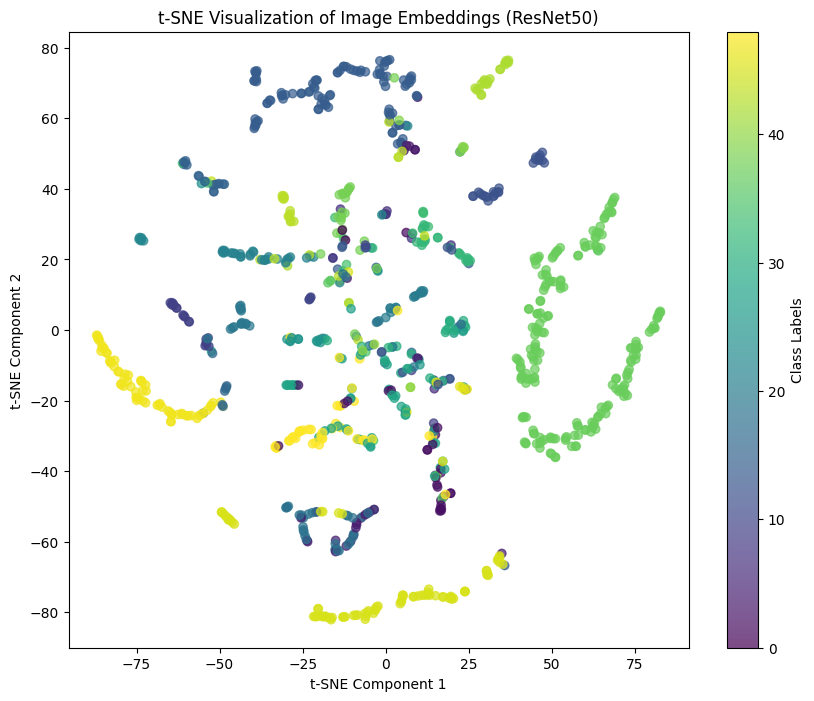

In [ ]:
intermediate_layer_model31 = tf.keras.Model(inputs=inception_model1.input, outputs=inception_model1.get_layer('global_average_pooling2d_3').output)

image_embeddings31 = inception_model1.predict(x_train)

tsne31 = TSNE(n_components=2, random_state=42, perplexity=5)
reduced_embeddings31 = tsne31.fit_transform(image_embeddings31)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings31[:, 0], reduced_embeddings31[:, 1], c=np.argmax(y_train, axis=1), cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class Labels')
plt.title("t-SNE Visualization of Image Embeddings (ResNet50)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [ ]:
fig = go.Figure(data=go.Scatter(
    x=reduced_embeddings31[:, 0],
    y=reduced_embeddings31[:, 1],
    mode='markers+text',
    marker=dict(color=np.argmax(y_train, axis=1)),
    text=[f"Class: {label}" for label in np.argmax(y_train, axis=1)]
))

fig.update_layout(
    title="t-SNE Visualization of Image Embeddings (Plotly)",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2",
    height=800
)

fig.show()

In [ ]:
df['image_embedding3'] = [[] for _ in range(len(df))]

for i in range(min(len(df), len(image_embeddings3))):
    df.at[i, 'image_embedding3'] = image_embeddings3[i].tolist()

df.to_parquet('df_with_embeddings3.parquet')

from google.colab import files
files.download('df_with_embeddings3.parquet')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(f"Nombre de lignes complétées : {df['image_embedding3'].apply(lambda x: len(x) > 0).sum()} sur {len(df)}")

Nombre de lignes complétées : 976 sur 1428


In [ ]:
df.head()

,website_name,competence_date,country_code,currency_code,brand,category1_code,category2_code,category3_code,product_code,title,itemurl,imageurl,full_price,price,full_price_eur,price_eur,flg_discount,image_embedding2,image_embedding3
0,Chanel,2023-11-17,DEU,EUR,CHANEL,FASHION,HANDBAGS,N.A.,PAS4152B13455,Tweed & goldfarbenes Metall Schwarz Rosa & B...,https://www.chanel.com/de/mode/p/AS4152B13455N...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5200.0,5200.0,5200.0,5200.0,0,"[0.047071319073438644, 0.0, 0.0469184592366218...","[0.0008268929086625576, 0.00011095630179625005..."
1,Chanel,2023-11-17,DEU,EUR,CHANEL,FASHION,HANDBAGS,N.A.,PA67085Y09953,n.a.,https://www.chanel.com/de/mode/p/A67085Y099539...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5750.0,5750.0,5750.0,5750.0,0,"[0.0, 0.001596460584551096, 0.3064392209053039...","[0.00032204296439886093, 0.0001457850157748907..."
2,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,BLUE LIGHT GLASSES,N.A.,PA71441,Schwarz,https://www.chanel.com/de/brillen/p/A71441X081...,https://res.cloudinary.com/dwayrkp5z/image/fet...,420.0,420.0,420.0,420.0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.05442395806312561,...","[3.999461569037521e-06, 9.973388159778551e-07,..."
3,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,SUNGLASSES,N.A.,PA71449,Silberfarben. Gläser: Braun Mit Verlauf,https://www.chanel.com/de/brillen/p/A71449X099...,https://res.cloudinary.com/dwayrkp5z/image/fet...,580.0,580.0,580.0,580.0,0,"[0.0, 0.018143076449632645, 0.0, 0.00900305900...","[2.9036164050921798e-05, 4.731273656943813e-05..."
4,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,SUNGLASSES,N.A.,PA71466,Blau & Rosa. Gläser: Grau Mit Verlauf,https://www.chanel.com/de/brillen/p/A71466X010...,https://res.cloudinary.com/dwayrkp5z/image/fet...,480.0,480.0,480.0,480.0,0,"[0.0, 0.0, 0.0, 0.012996802106499672, 0.0, 0.1...","[0.007141607813537121, 0.008937004022300243, 0..."


## **Comparaison des deux méthodes :**

* **Analyser la qualité des embeddings sur des critères comme la cohérence intra-classe et les distances inter-classe pour le modèle ResNet50**





In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances

df = pd.read_parquet('df_with_embeddings3.parquet')
product_indices = [0, 10, 100, 1000]

def calculate_distances(df, product_indices):
    """Calculates cosine similarity between specified product embeddings."""
    valid_indices = [i for i in product_indices if i < len(df)]
    embeddings = df.loc[valid_indices, 'image_embedding2'].to_list()

    if not embeddings:
        return pd.DataFrame(index=[], columns=[])

    embedding_length = len(embeddings[0])
    embeddings = [emb for emb in embeddings if len(emb) == embedding_length]

    valid_indices = valid_indices[:len(embeddings)]

    embeddings = np.array(embeddings)

    distances = cosine_similarity(embeddings)

    return pd.DataFrame(distances, index=valid_indices, columns=valid_indices)

distances_df = calculate_distances(df, product_indices)
print("Cosine Similarity Matrix:")
print(distances_df)


def most_similar_products(df, product_index, top_n=3):
  """Finds the top N most similar products to the given product."""
  if product_index not in df.index:
    return pd.Series(dtype=float)
  similarities = df.loc[product_index].drop(index=product_index)
  most_similar = similarities.nlargest(top_n)
  return most_similar

for index in distances_df.index:
    similar_products = most_similar_products(distances_df, index)
    print(f"\nMost similar products to product {index}:")
    print(similar_products)


def analyze_embeddings(embeddings, labels):
    """Analyzes embedding quality."""
    unique_labels = np.unique(labels[:len(embeddings)])
    n_classes = len(unique_labels)

    intraclass_distances = []
    interclass_distances = []
    intraclass_variability = {}
    interclass_variability = {}

    for label in unique_labels:
        class_indices = np.where(labels[:len(embeddings)] == label)[0]
        class_embeddings = embeddings[class_indices]
        distances = pairwise_distances(class_embeddings)

        upper_triangle_indices = np.triu_indices(len(distances), k=1)
        intraclass_distances.extend(distances[upper_triangle_indices])
        intraclass_variability[label] = np.std(distances[upper_triangle_indices])

        for other_label in unique_labels:
            if label != other_label:
                other_indices = np.where(labels[:len(embeddings)] == other_label)[0]
                other_embeddings = embeddings[other_indices]
                distances = pairwise_distances(class_embeddings, other_embeddings)
                interclass_distances.extend(distances.flatten())
                interclass_variability[(label, other_label)] = np.std(distances.flatten())

    avg_intraclass_distance = np.mean(intraclass_distances)
    avg_interclass_distance = np.mean(interclass_distances)

    return {
        "average_intraclass_distance": avg_intraclass_distance,
        "average_interclass_distance": avg_interclass_distance,
        "intraclass_variability": intraclass_variability,
        "interclass_variability": interclass_variability,
    }

labels = df['category2_code'].values
analysis_results = analyze_embeddings(reduced_embeddings2, labels)
print("\nEmbedding Analysis Results:")
for key, value in analysis_results.items():
    print(f"{key}: {value}")

Cosine Similarity Matrix:
          0         10        100
0    1.000000  0.728838  0.714356
10   0.728838  1.000000  0.585493
100  0.714356  0.585493  1.000000

Most similar products to product 0:
10     0.728838
100    0.714356
Name: 0, dtype: float64

Most similar products to product 10:
0      0.728838
100    0.585493
Name: 10, dtype: float64

Most similar products to product 100:
0     0.714356
10    0.585493
Name: 100, dtype: float64


In [ ]:
labels = df['category2_code'].values
analysis_results = analyze_embeddings(reduced_embeddings31, labels)
print("\nEmbedding Analysis Results:")
for key, value in analysis_results.items():
    print(f"{key}: {value}")

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist


Embedding Analysis Results:
average_intraclass_distance: 71.28108978271484
average_interclass_distance: 71.8941650390625
intraclass_variability: {'1.5 1 CAMELIA. 5 ALLURES': nan, '1932 COLLECTION (2022)': 0.0, 'BATH AND BODY': 38.059605, 'BELTS': 25.786524, 'BLUE LIGHT GLASSES': 33.218777, 'BRACELETS': 26.391705, 'BROOCHES': 24.448757, 'BRUSHES AND ACCESSORIES': 28.186424, 'CAMELLIAS': 32.40124, 'CLEANSERS & MAKEUP REMOVERS': 42.428173, 'COCO CRUSH': 30.532127, 'COMETE': 32.00352, 'COSTUME JEWELRY': 33.986168, 'EARRINGS': 31.27279, 'EXCEPTIONAL PIECES': 36.16911, 'EYE & LIP CARE': 37.844902, 'EYEGLASSES': 33.940098, 'EYES': 35.61669, 'FACE': 35.82568, 'HANDBAGS': 34.959236, 'HEADWEAR': 38.46162, "L'ESPRIT DU LION": nan, 'LES EXCLUSIFS DE CHANEL': nan, 'LES INTEMPORELS DE CHANEL': 0.0, 'LIPS': 37.342285, 'MASKS & EXFOLIATORS': 28.826319, 'MASSAGE ACCESSORIES': nan, 'MEN': 35.248955, 'MISTS': 0.0, 'MOISTURIZERS': 31.294397, 'NAILS': 20.807243, 'NECKLACES': 34.80311, 'N°5': 32.633244, 'N

* **Sélectionner des exemples représentatifs (par exemple, un sac, un parfum, un produit cosmétique) et comparer les distances entre leurs embeddings générés par les trois méthodes**

* **Comparaison du modèle CNN et le modèle ResNet50**

In [ ]:
product_categories = ['EYEGLASSES', 'BROOCHES', 'COCO CRUSH']

def get_product_indices_by_category(df, category):
    return df[df['category2_code'] == category].index.tolist()

# Obtenir les index de produits pour chaque catégorie
product_indices_dict = {}
for category in product_categories:
    product_indices = get_product_indices_by_category(df, category)
    if product_indices:
        # Sélectionner 5 produits par catégorie
        product_indices_dict[category] = product_indices[:5]
    else:
        print(f"Aucun produit trouvé pour la catégorie : {category}")

# Fonction pour calculer la similarité cosinus pour une liste de produits
def calculate_distances(embeddings):
    if embeddings:
        embeddings = np.array(embeddings)
        distances = cosine_similarity(embeddings)
        return pd.DataFrame(distances)
    else:
        return pd.DataFrame()

# Calculer les distances et imprimer les résultats pour chaque catégorie
for category, indices in product_indices_dict.items():
    embeddings_model = [df.loc[i, 'image_embedding'] for i in indices]
    embeddings_model2 = [df.loc[i, 'image_embedding2'] for i in indices]
    distances_model = calculate_distances(embeddings_model)
    distances_model2 = calculate_distances(embeddings_model2)
    print(f"\nSimilarité cosinus pour {category} (model) :")
    print(distances_model)
    print(f"\nSimilarité cosinus pour {category} (model2) :")
    print(distances_model2)

    # Comparer les distances
    if not distances_model.empty and not distances_model2.empty:
        distance_diff = distances_model - distances_model2
        print(f"\nDifférence de distance pour {category} :")
        print(distance_diff)


Similarité cosinus pour EYEGLASSES (model) :
          0         1         2         3         4
0  1.000000  0.342710  0.313998  0.464827  0.379856
1  0.342710  1.000000  0.243131  0.144592  0.076396
2  0.313998  0.243131  1.000000  0.399295  0.523101
3  0.464827  0.144592  0.399295  1.000000  0.507619
4  0.379856  0.076396  0.523101  0.507619  1.000000

Similarité cosinus pour EYEGLASSES (model2) :
          0         1         2         3         4
0  1.000000  0.143474  0.372954  0.223176  0.135397
1  0.143474  1.000000  0.259913  0.184838  0.664801
2  0.372954  0.259913  1.000000  0.249737  0.238309
3  0.223176  0.184838  0.249737  1.000000  0.221274
4  0.135397  0.664801  0.238309  0.221274  1.000000

Différence de distance pour EYEGLASSES :
              0             1             2             3             4
0 -1.321165e-14  1.992354e-01 -5.895673e-02  2.416511e-01  2.444591e-01
1  1.992354e-01 -2.453593e-14 -1.678195e-02 -4.024571e-02 -5.884045e-01
2 -5.895673e-02 -1.678195

* **Comparaison entre deux modèle pré-entrainé**

In [ ]:
product_categories = ['EYEGLASSES', 'BROOCHES', 'COCO CRUSH']

# Obtenir les index de produits pour chaque catégorie
product_indices_dict = {}
for category in product_categories:
    product_indices = get_product_indices_by_category(df, category)
    if product_indices:
        # Sélectionner 5 produits par catégorie
        product_indices_dict[category] = product_indices[:5]
    else:
        print(f"Aucun produit trouvé pour la catégorie : {category}")

# Calculer les distances et imprimer les résultats pour chaque catégorie
for category, indices in product_indices_dict.items():
    embeddings_model = [df.loc[i, 'image_embedding2'] for i in indices]
    embeddings_model2 = [df.loc[i, 'image_embedding3'] for i in indices]
    distances_model = calculate_distances(embeddings_model)
    distances_model2 = calculate_distances(embeddings_model2)
    print(f"\nSimilarité cosinus pour {category} (Resnet) :")
    print(distances_model)
    print(f"\nSimilarité cosinus pour {category} (Inception) :")
    print(distances_model2)

    # Comparer les distances
    if not distances_model.empty and not distances_model2.empty:
        distance_diff = distances_model - distances_model2
        print(f"\nDifférence de distance pour {category} :")
        print(distance_diff)


Similarité cosinus pour EYEGLASSES (Resnet) :
          0         1         2         3         4
0  1.000000  0.396976  0.941858  0.517172  0.362949
1  0.396976  1.000000  0.436286  0.694018  0.801364
2  0.941858  0.436286  1.000000  0.574771  0.408929
3  0.517172  0.694018  0.574771  1.000000  0.706542
4  0.362949  0.801364  0.408929  0.706542  1.000000

Similarité cosinus pour EYEGLASSES (Inception) :
          0         1         2         3         4
0  1.000000  0.001165  0.027064  0.010097  0.076041
1  0.001165  1.000000  0.181097  0.797910  0.010025
2  0.027064  0.181097  1.000000  0.457192  0.079671
3  0.010097  0.797910  0.457192  1.000000  0.016977
4  0.076041  0.010025  0.079671  0.016977  1.000000

Différence de distance pour EYEGLASSES :
              0             1             2             3             4
0  9.992007e-16  3.958114e-01  9.147943e-01  5.070754e-01  2.869083e-01
1  3.958114e-01 -1.110223e-16  2.551895e-01 -1.038916e-01  7.913388e-01
2  9.147943e-01  2.55

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(distances_model, annot=True, cmap='coolwarm', fmt='.2f')
plt.title(f"Cosine Similarity Heatmap for {category} (Model 1)")
plt.show()

sns.heatmap(distances_model2, annot=True, cmap='coolwarm', fmt='.2f')
plt.title(f"Cosine Similarity Heatmap for {category} (Model 2)")
plt.show()

* **Plot des embeddings visuels produitent par le ré-entrainement de ResNet via UMAP**

In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.3 MB/s eta 0:00:00


In [ ]:
import plotly.graph_objects as go
import numpy as np
import umap

def plot_umap_embeddings(embeddings, labels, model_name):
    reducer = umap.UMAP(n_components=2, random_state=42)
    reduced_embeddings = reducer.fit_transform(embeddings)

    fig = go.Figure(data=go.Scatter(
        x=reduced_embeddings[:, 0],
        y=reduced_embeddings[:, 1],
        mode='markers',
        marker=dict(color=labels),
        text=[f"Class: {label}" for label in labels]
    ))

    fig.update_layout(
        title=f"UMAP Visualization of Image Embeddings ({model_name})",
        xaxis_title="UMAP Component 1",
        yaxis_title="UMAP Component 2",
        height=800
    )
    fig.show()


plot_umap_embeddings(image_embeddings2, np.argmax(y_train, axis=1), "model2")

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



* **Plot des embeddings visuels du modèle Inception via UMAP**

In [ ]:
plot_umap_embeddings(image_embeddings31, np.argmax(y_train, axis=1), "inception_model1")

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

